# 02 — Exploratory Data Analysis
## HumanForYou — Employee Attrition Prediction

---

### Objective

Perform a **comprehensive EDA** to:
1. Understand the distribution of each feature
2. Identify correlations and patterns linked to attrition
3. Detect potential biases in sensitive variables (gender, age, marital status)
4. Generate visual insights to guide feature engineering and model selection

> This notebook expects `merged_data.csv` from **01_Data_Validation_Pipeline**.

## Section 1: Setup & Data Loading

In [ ]:
# ==============================================================================
# IMPORTS AND CONFIGURATION
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from pathlib import Path

# Only suppress expected warnings, not real errors
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Plotting config
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.dpi": 100,
    "font.size": 11,
})
sns.set_theme(style="whitegrid", palette="muted")

# --- Path Configuration ---
_cwd = Path.cwd()
if (_cwd / "data" / "raw").exists():
    PROJECT_ROOT = _cwd
elif (_cwd.parent / "data" / "raw").exists():
    PROJECT_ROOT = _cwd.parent
else:
    PROJECT_ROOT = Path(r"c:\Users\yanis\Documents\CESI\A5\AI Project\HumanForYou")

OUTPUT_DIR = str(PROJECT_ROOT / "outputs")

df = pd.read_csv(f"{OUTPUT_DIR}/merged_data.csv")

# Encode target as binary for analysis
df["Attrition_binary"] = (df["Attrition"] == "Yes").astype(int)

print(f"Dataset loaded: {df.shape[0]} employees x {df.shape[1]} features")
print(f"Attrition: {df['Attrition_binary'].sum()} Yes ({df['Attrition_binary'].mean()*100:.1f}%) / {(df['Attrition_binary']==0).sum()} No")

## Section 2: Target Variable Analysis

**Key question**: How imbalanced is the attrition class? This will drive our choice of metrics and resampling strategy.

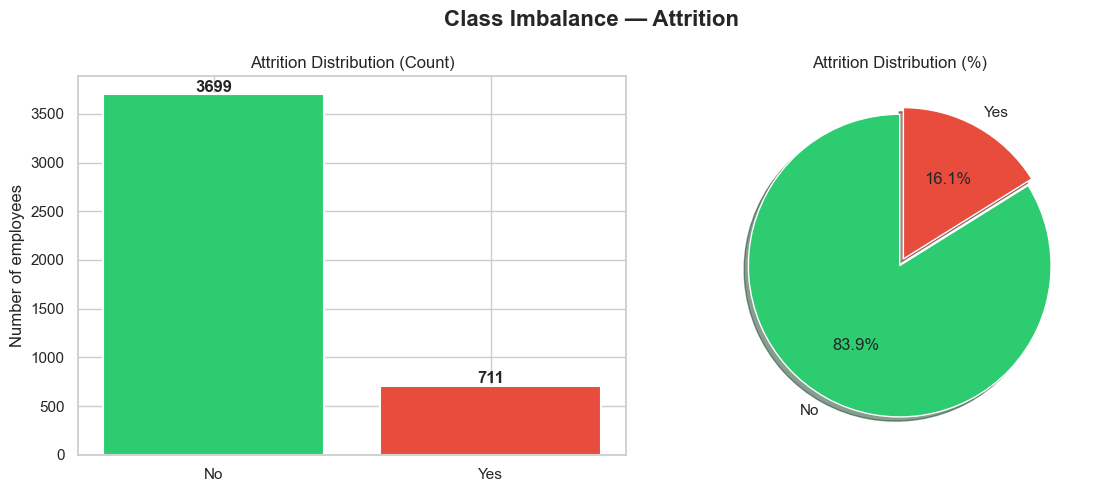

Imbalance ratio (minority/majority): 0.192
→ Significant imbalance — consider SMOTE or class_weight adjustments


In [2]:
# ==============================================================================
# TARGET DISTRIBUTION
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
counts = df["Attrition"].value_counts()
colors = ["#2ecc71", "#e74c3c"]
axes[0].bar(counts.index, counts.values, color=colors, edgecolor="white", linewidth=1.5)
axes[0].set_title("Attrition Distribution (Count)")
axes[0].set_ylabel("Number of employees")
for i, (idx, val) in enumerate(counts.items()):
    axes[0].text(i, val + 30, str(val), ha="center", fontweight="bold")

# Pie chart
axes[1].pie(counts.values, labels=counts.index, autopct="%1.1f%%", colors=colors,
            startangle=90, explode=(0, 0.05), shadow=True)
axes[1].set_title("Attrition Distribution (%)")

plt.suptitle("Class Imbalance — Attrition", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_target_distribution.png", bbox_inches="tight")
plt.show()

imbalance_ratio = counts.min() / counts.max()
print(f"Imbalance ratio (minority/majority): {imbalance_ratio:.3f}")
print(f"→ {'Moderate' if imbalance_ratio > 0.2 else 'Significant'} imbalance — consider SMOTE or class_weight adjustments")

## Section 3: Numerical Features Analysis

Distributions, box plots by attrition, and statistical tests to identify significant differences.

In [3]:
# ==============================================================================
# NUMERICAL FEATURE DISTRIBUTIONS BY ATTRITION
# ==============================================================================

num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [c for c in num_cols if c not in ["EmployeeID", "Attrition_binary"]]

# Statistical test: Mann-Whitney U for each numerical feature
print("MANN-WHITNEY U TEST — Numerical features vs Attrition")
print("=" * 65)

stat_results = []
for col in num_cols:
    group_yes = df.loc[df["Attrition_binary"] == 1, col].dropna()
    group_no  = df.loc[df["Attrition_binary"] == 0, col].dropna()
    if len(group_yes) > 0 and len(group_no) > 0:
        u_stat, p_val = stats.mannwhitneyu(group_yes, group_no, alternative="two-sided")
        stat_results.append({"feature": col, "U_statistic": u_stat, "p_value": p_val})

df_stats = pd.DataFrame(stat_results).sort_values("p_value")
df_stats["significant"] = df_stats["p_value"] < 0.05

significant_features = df_stats[df_stats["significant"]]["feature"].tolist()
print(f"\n{len(significant_features)} features significantly different between groups (p < 0.05):")
for _, row in df_stats[df_stats["significant"]].iterrows():
    print(f"  → {row['feature']:30s} p = {row['p_value']:.2e}")

MANN-WHITNEY U TEST — Numerical features vs Attrition

13 features significantly different between groups (p < 0.05):
  → TotalWorkingYears              p = 1.93e-39
  → avg_departure_hour             p = 7.81e-37
  → avg_working_hours              p = 8.11e-37
  → YearsAtCompany                 p = 1.21e-36
  → YearsWithCurrManager           p = 2.47e-31
  → Age                            p = 5.99e-30
  → JobSatisfaction                p = 1.27e-11
  → EnvironmentSatisfaction        p = 2.66e-10
  → YearsSinceLastPromotion        p = 4.04e-04
  → WorkLifeBalance                p = 8.56e-04
  → absence_rate                   p = 6.55e-03
  → TrainingTimesLastYear          p = 1.03e-02
  → PercentSalaryHike              p = 3.73e-02


C:\Users\yanis\AppData\Local\Temp\ipykernel_28048\4276853669.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Attrition", y=col, ax=axes[i], palette=colors, order=["No", "Yes"])
C:\Users\yanis\AppData\Local\Temp\ipykernel_28048\4276853669.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Attrition", y=col, ax=axes[i], palette=colors, order=["No", "Yes"])
C:\Users\yanis\AppData\Local\Temp\ipykernel_28048\4276853669.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Attrition", y=col, ax=axes[i], pa

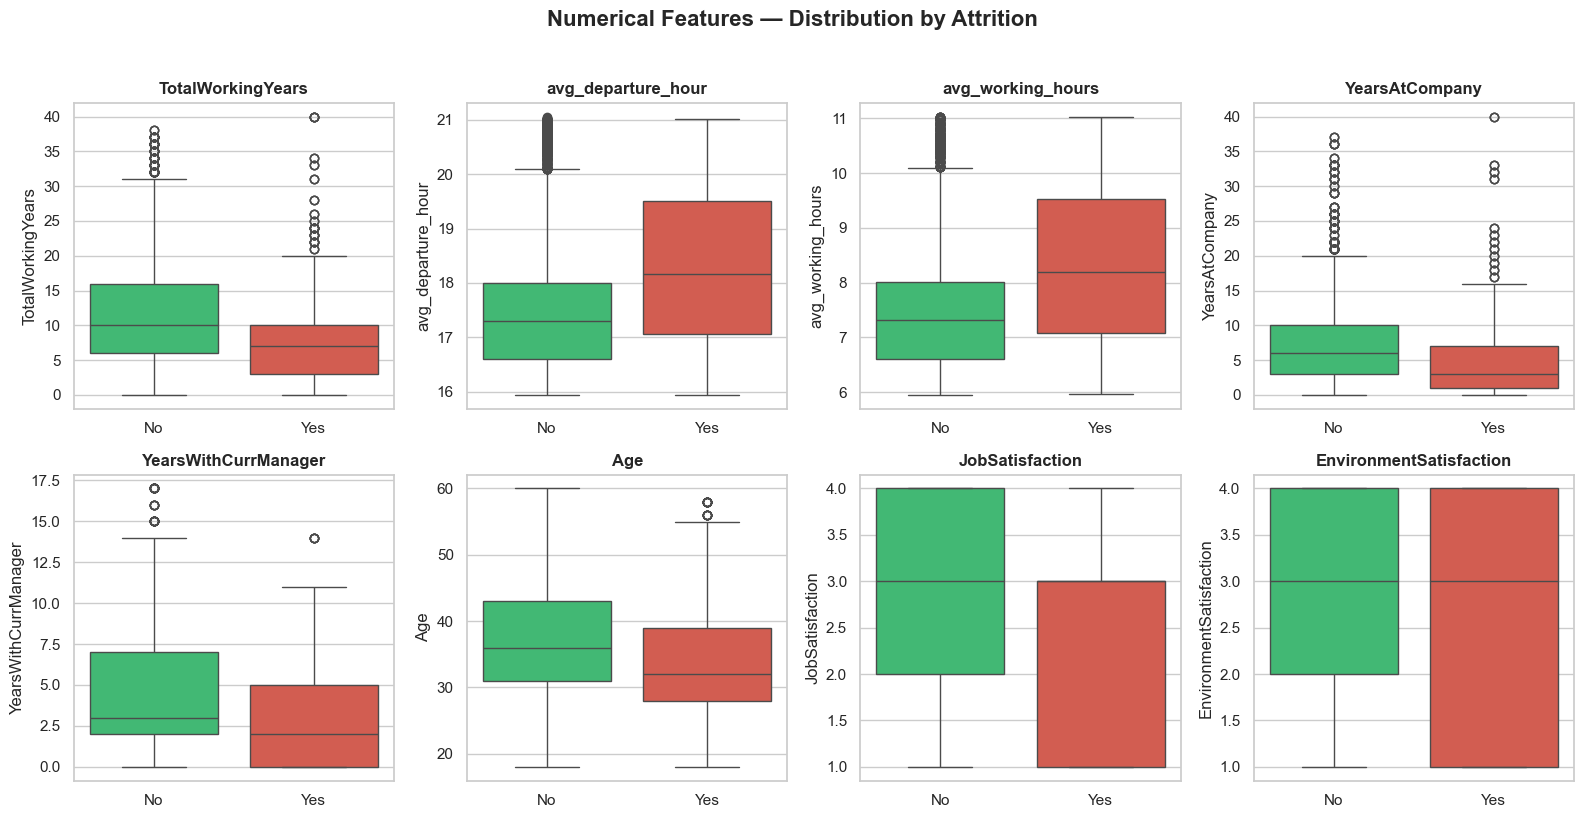

In [4]:
# ==============================================================================
# BOX PLOTS — Top significant numerical features by attrition
# ==============================================================================

top_features = significant_features[:8]  # top 8
n_plots = len(top_features)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(top_features):
    sns.boxplot(data=df, x="Attrition", y=col, ax=axes[i], palette=colors, order=["No", "Yes"])
    axes[i].set_title(col, fontweight="bold")
    axes[i].set_xlabel("")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Numerical Features — Distribution by Attrition", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_numerical_boxplots.png", bbox_inches="tight")
plt.show()

## Section 3b: Outlier Detection (IQR method)

Identify extreme values that could distort models. Uses the **Interquartile Range (IQR)** rule: any value below Q1 - 1.5*IQR or above Q3 + 1.5*IQR is flagged as an outlier.

In [ ]:
# ==============================================================================
# OUTLIER DETECTION — IQR Method
# ==============================================================================

print("OUTLIER ANALYSIS (IQR method — 1.5x)")
print("=" * 65)

outlier_report = []
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct = n_outliers / len(df) * 100
    outlier_report.append({
        "feature": col, "Q1": Q1, "Q3": Q3, "IQR": IQR,
        "lower_bound": lower, "upper_bound": upper,
        "n_outliers": n_outliers, "pct_outliers": pct
    })

df_outliers = pd.DataFrame(outlier_report).sort_values("n_outliers", ascending=False)
df_with_outliers = df_outliers[df_outliers["n_outliers"] > 0]

print(f"\n{len(df_with_outliers)} features have outliers:")
for _, row in df_with_outliers.iterrows():
    print(f"  {row['feature']:30s} {int(row['n_outliers']):>4} outliers ({row['pct_outliers']:.1f}%)")

# Visualize top features with outliers
top_outlier_features = df_with_outliers.head(6)["feature"].tolist()
if top_outlier_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for i, col in enumerate(top_outlier_features):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        sns.boxplot(data=df, y=col, x="Attrition", ax=axes[i], palette=colors, order=["No", "Yes"])
        axes[i].axhline(upper, color="red", linestyle="--", alpha=0.5, label=f"Upper bound ({upper:.1f})")
        axes[i].axhline(lower, color="blue", linestyle="--", alpha=0.5, label=f"Lower bound ({lower:.1f})")
        n_out = int(df_with_outliers.loc[df_with_outliers["feature"] == col, "n_outliers"].values[0])
        axes[i].set_title(f"{col}\n({n_out} outliers)", fontweight="bold")
        axes[i].legend(fontsize=8)

    for j in range(len(top_outlier_features), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle("Outlier Detection — IQR Method (top 6 features)", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/eda_outlier_detection.png", bbox_inches="tight")
    plt.show()

print(f"\nNote: Outliers are NOT removed at this stage — they will be handled during preprocessing.")

In [5]:
# ==============================================================================
# CATEGORICAL FEATURES — Chi-squared tests and attrition rates
# ==============================================================================

cat_cols = df.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != "Attrition"]

print("CHI-SQUARED TEST — Categorical features vs Attrition")
print("=" * 65)

chi2_results = []
for col in cat_cols:
    ct = pd.crosstab(df[col], df["Attrition"])
    chi2, p_val, dof, expected = stats.chi2_contingency(ct)
    chi2_results.append({"feature": col, "chi2": chi2, "p_value": p_val, "dof": dof})

df_chi2 = pd.DataFrame(chi2_results).sort_values("p_value")
df_chi2["significant"] = df_chi2["p_value"] < 0.05

for _, row in df_chi2.iterrows():
    sig = "**" if row["significant"] else "  "
    print(f"  {sig} {row['feature']:25s} χ² = {row['chi2']:8.2f}  p = {row['p_value']:.2e}")

CHI-SQUARED TEST — Categorical features vs Attrition
  ** MaritalStatus             χ² =   138.49  p = 8.45e-31
  ** BusinessTravel            χ² =    72.55  p = 1.76e-16
  ** EducationField            χ² =    46.19  p = 8.29e-09
  ** Department                χ² =    29.09  p = 4.82e-07
  ** JobRole                   χ² =    25.12  p = 1.49e-03
     Gender                    χ² =     1.35  p = 2.45e-01


C:\Users\yanis\AppData\Local\Temp\ipykernel_28048\2035513946.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include="object").columns.tolist()


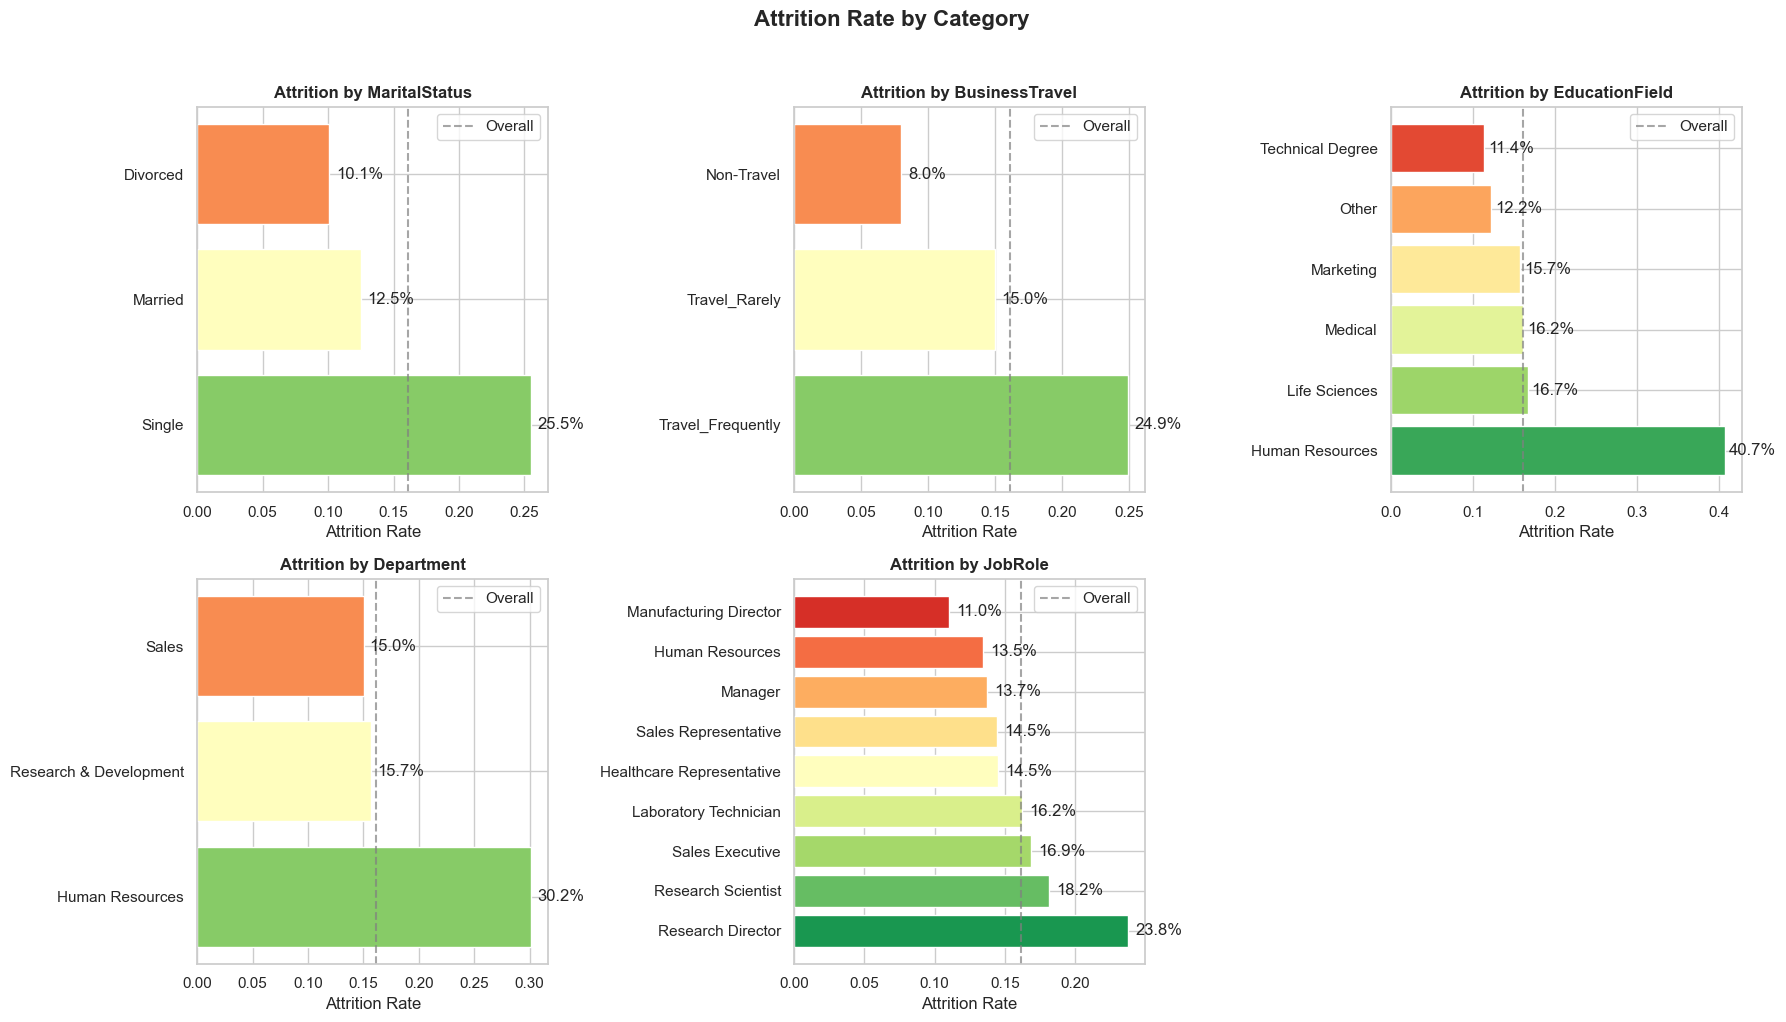

In [6]:
# ==============================================================================
# ATTRITION RATE BY CATEGORICAL FEATURE
# ==============================================================================

sig_cat = df_chi2[df_chi2["significant"]]["feature"].tolist()
n_plots = len(sig_cat)
n_cols = min(3, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
if n_plots == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, col in enumerate(sig_cat):
    rates = df.groupby(col)["Attrition_binary"].mean().sort_values(ascending=False)
    axes[i].barh(rates.index, rates.values, color=sns.color_palette("RdYlGn_r", len(rates)))
    axes[i].set_xlabel("Attrition Rate")
    axes[i].set_title(f"Attrition by {col}", fontweight="bold")
    axes[i].axvline(df["Attrition_binary"].mean(), color="gray", linestyle="--", alpha=0.7, label="Overall")
    axes[i].legend()
    # Add value labels
    for j, val in enumerate(rates.values):
        axes[i].text(val + 0.005, j, f"{val:.1%}", va="center")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Attrition Rate by Category", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_categorical_attrition.png", bbox_inches="tight")
plt.show()

## Section 5: Correlation Analysis

Heatmap of numerical features and point-biserial correlations with the target.

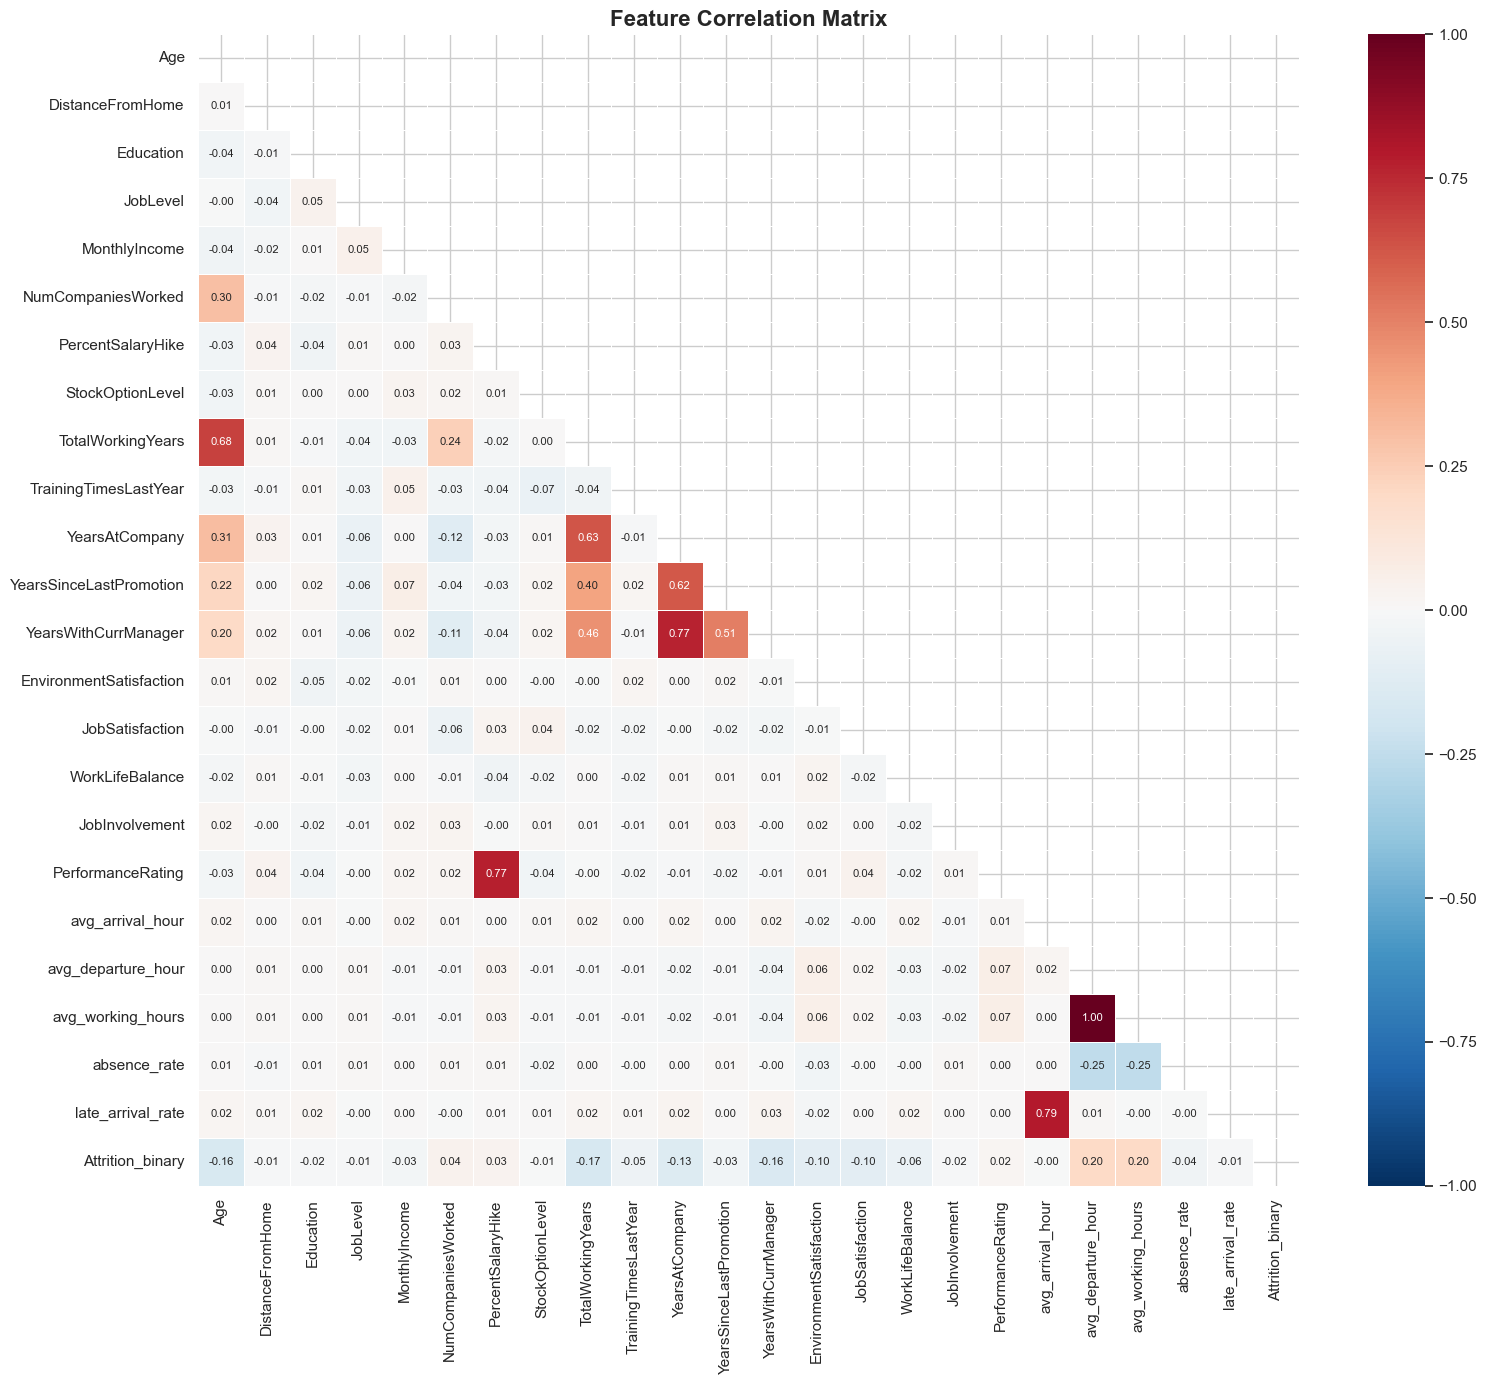

In [7]:
# ==============================================================================
# CORRELATION HEATMAP
# ==============================================================================

# Select numerical columns (including binary target)
corr_cols = [c for c in num_cols if c not in ["EmployeeID"]] + ["Attrition_binary"]
corr_matrix = df[corr_cols].corr()

# Full heatmap
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, linewidths=0.5, ax=ax,
            annot_kws={"size": 8})
ax.set_title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_correlation_heatmap.png", bbox_inches="tight")
plt.show()

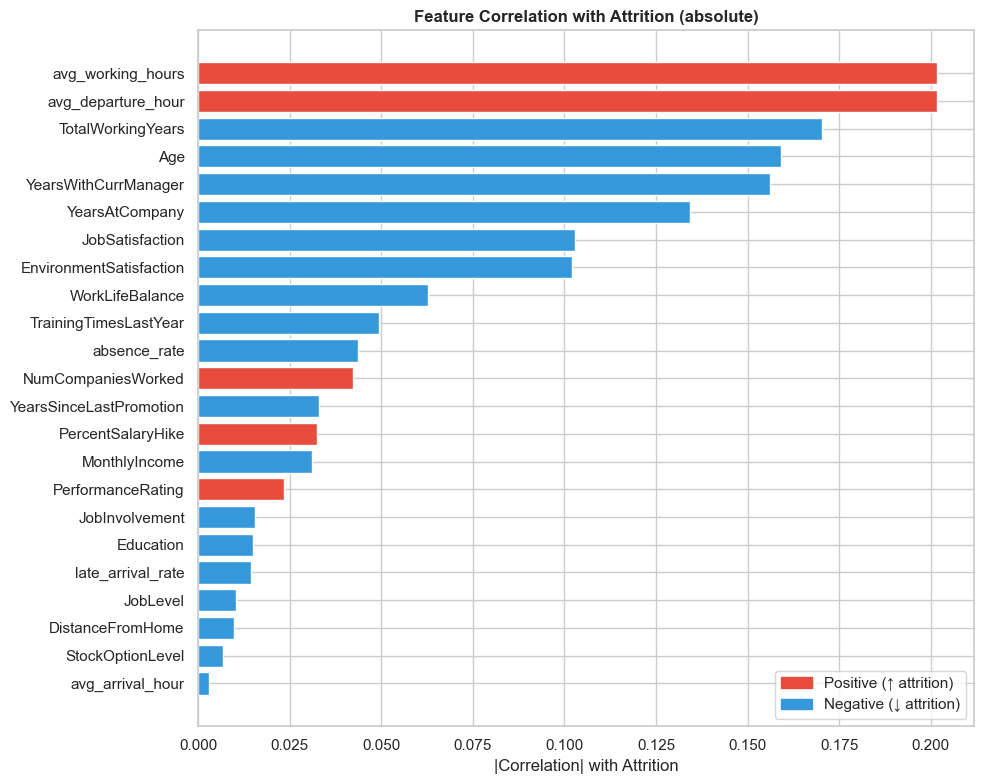

Top 10 features correlated with Attrition:
  + avg_working_hours              |r| = 0.202
  + avg_departure_hour             |r| = 0.202
  − TotalWorkingYears              |r| = 0.170
  − Age                            |r| = 0.159
  − YearsWithCurrManager           |r| = 0.156
  − YearsAtCompany                 |r| = 0.134
  − JobSatisfaction                |r| = 0.103
  − EnvironmentSatisfaction        |r| = 0.102
  − WorkLifeBalance                |r| = 0.063
  − TrainingTimesLastYear          |r| = 0.049


In [8]:
# ==============================================================================
# TOP CORRELATIONS WITH ATTRITION
# ==============================================================================

target_corr = corr_matrix["Attrition_binary"].drop("Attrition_binary").abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors_corr = ["#e74c3c" if corr_matrix.loc[feat, "Attrition_binary"] > 0 else "#3498db" 
               for feat in target_corr.index]
ax.barh(target_corr.index, target_corr.values, color=colors_corr)
ax.set_xlabel("|Correlation| with Attrition")
ax.set_title("Feature Correlation with Attrition (absolute)", fontweight="bold")
ax.invert_yaxis()

# Add a legend
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color="#e74c3c", label="Positive (↑ attrition)"),
                   Patch(color="#3498db", label="Negative (↓ attrition)")],
          loc="lower right")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_target_correlations.png", bbox_inches="tight")
plt.show()

print("Top 10 features correlated with Attrition:")
for feat, val in target_corr.head(10).items():
    direction = "+" if corr_matrix.loc[feat, "Attrition_binary"] > 0 else "−"
    print(f"  {direction} {feat:30s} |r| = {val:.3f}")

## Section 5b: Interactive Exploration (Plotly)

Interactive scatter plot to explore the relationship between key features, salary, and attrition.

In [ ]:
# ==============================================================================
# INTERACTIVE PLOT — Plotly (Age vs Income vs Attrition)
# ==============================================================================

import plotly.express as px

fig = px.scatter(
    df,
    x="Age",
    y="MonthlyIncome",
    color="Attrition",
    size="YearsAtCompany",
    hover_data=["JobRole", "Department", "JobLevel", "DistanceFromHome"],
    color_discrete_map={"No": "#2ecc71", "Yes": "#e74c3c"},
    opacity=0.6,
    title="Interactive: Age vs Monthly Income by Attrition<br><sub>Bubble size = Years at Company. Hover for details.</sub>",
    labels={"MonthlyIncome": "Monthly Income (Rupees)", "Age": "Age (years)"},
)

fig.update_layout(
    template="plotly_white",
    width=900,
    height=600,
    legend_title_text="Attrition",
)

fig.write_html(f"{OUTPUT_DIR}/eda_interactive_scatter.html")
fig.show()

print(f"Interactive plot saved to {OUTPUT_DIR}/eda_interactive_scatter.html")

## Section 6: Sensitive Variables — Equity Analysis

**Ethical checkpoint**: Examine the distribution of sensitive variables (Gender, Age, MaritalStatus) and their relationship with attrition to identify potential biases.

> This analysis feeds directly into the **ethics deliverable** (ALTAI Requirement 5: Diversity, Non-Discrimination and Equity).

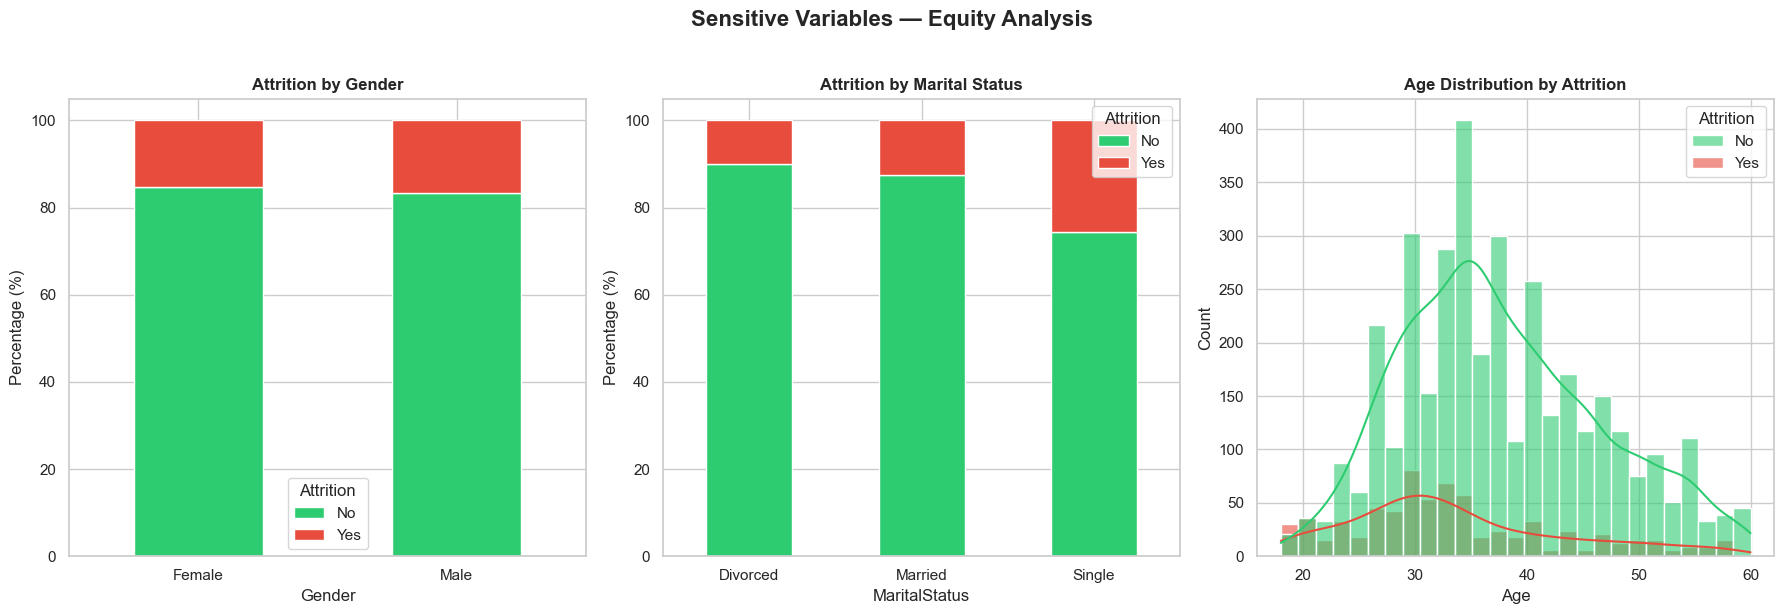

DISPARATE IMPACT — Gender
  Attrition rate Male:   0.167
  Attrition rate Female: 0.153
  Disparate Impact ratio: 0.918 ✓ (> 0.8 — 4/5 rule)


In [9]:
# ==============================================================================
# SENSITIVE VARIABLES — EQUITY ANALYSIS
# ==============================================================================

sensitive_vars = ["Gender", "MaritalStatus", "Age"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender × Attrition
ct_gender = pd.crosstab(df["Gender"], df["Attrition"], normalize="index") * 100
ct_gender.plot(kind="bar", stacked=True, ax=axes[0], color=colors)
axes[0].set_title("Attrition by Gender", fontweight="bold")
axes[0].set_ylabel("Percentage (%)")
axes[0].legend(title="Attrition")
axes[0].tick_params(axis="x", rotation=0)

# MaritalStatus × Attrition
ct_marital = pd.crosstab(df["MaritalStatus"], df["Attrition"], normalize="index") * 100
ct_marital.plot(kind="bar", stacked=True, ax=axes[1], color=colors)
axes[1].set_title("Attrition by Marital Status", fontweight="bold")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(title="Attrition")
axes[1].tick_params(axis="x", rotation=0)

# Age distribution by Attrition
sns.histplot(data=df, x="Age", hue="Attrition", kde=True, ax=axes[2],
             palette={"No": "#2ecc71", "Yes": "#e74c3c"}, alpha=0.6)
axes[2].set_title("Age Distribution by Attrition", fontweight="bold")

plt.suptitle("Sensitive Variables — Equity Analysis", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_equity_analysis.png", bbox_inches="tight")
plt.show()

# Disparate impact calculation
print("DISPARATE IMPACT — Gender")
print("=" * 65)
rate_male   = df.loc[df["Gender"] == "Male",   "Attrition_binary"].mean()
rate_female = df.loc[df["Gender"] == "Female", "Attrition_binary"].mean()
di = min(rate_male, rate_female) / max(rate_male, rate_female)
print(f"  Attrition rate Male:   {rate_male:.3f}")
print(f"  Attrition rate Female: {rate_female:.3f}")
print(f"  Disparate Impact ratio: {di:.3f} {'✓ (> 0.8 — 4/5 rule)' if di > 0.8 else '⚠ (< 0.8 — potential bias)'}")

## Section 7: Key EDA Findings — Summary

In [10]:
# ==============================================================================
# EDA SUMMARY
# ==============================================================================

print("=" * 65)
print("EDA KEY FINDINGS")
print("=" * 65)
print(f"""
1. CLASS IMBALANCE
   Attrition rate: ~{df['Attrition_binary'].mean()*100:.0f}% — moderate imbalance.
   → Recommendation: Use stratified splits, consider SMOTE, optimize for Recall/F1.

2. SIGNIFICANT NUMERICAL FEATURES (p < 0.05)
   {', '.join(significant_features[:5])}...
   → These should be prioritized in feature selection.

3. SIGNIFICANT CATEGORICAL FEATURES (p < 0.05)
   {', '.join(sig_cat)}
   → Encode carefully; consider target encoding for high-cardinality features.

4. CORRELATION HIGHLIGHTS
   Top positive: features pushing toward attrition
   Top negative: features protecting against attrition
   → Check multicollinearity for highly correlated feature pairs.

5. EQUITY OBSERVATIONS
   Gender disparate impact ratio: {di:.3f}
   → {'Acceptable' if di > 0.8 else 'Requires mitigation'} per 4/5 rule.
   → Document in ethics deliverable.
""")
print("\n✓ EDA complete — proceed to 03_Feature_Engineering.ipynb")

EDA KEY FINDINGS

1. CLASS IMBALANCE
   Attrition rate: ~16% — moderate imbalance.
   → Recommendation: Use stratified splits, consider SMOTE, optimize for Recall/F1.

2. SIGNIFICANT NUMERICAL FEATURES (p < 0.05)
   TotalWorkingYears, avg_departure_hour, avg_working_hours, YearsAtCompany, YearsWithCurrManager...
   → These should be prioritized in feature selection.

3. SIGNIFICANT CATEGORICAL FEATURES (p < 0.05)
   MaritalStatus, BusinessTravel, EducationField, Department, JobRole
   → Encode carefully; consider target encoding for high-cardinality features.

4. CORRELATION HIGHLIGHTS
   Top positive: features pushing toward attrition
   Top negative: features protecting against attrition
   → Check multicollinearity for highly correlated feature pairs.

5. EQUITY OBSERVATIONS
   Gender disparate impact ratio: 0.918
   → Acceptable per 4/5 rule.
   → Document in ethics deliverable.


✓ EDA complete — proceed to 03_Feature_Engineering.ipynb
